### This notebook generate the line benefits from the operational cost

In [211]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [212]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [213]:
#%% Setting up the path a cases
DirName  = os.getcwd()

# CSV_name =  'OC_fy_1'
# CSV_name =  'OC_fy_2'
CSV_name =  'OC_fy_3'

CaseName_Base     = '3-bus'
CaseName_ByStages = '3-bus_'+CSV_name

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [214]:
df_1 = pd.read_csv('Estimated_'+CSV_name+'.csv', index_col=0)

In [215]:
# Assuming your DataFrame is named df
# Calculate the difference for each column
diff_df_1 = df_1.drop(columns=["Network_Existing_Generation_Full"]).subtract(df_1["Network_Existing_Generation_Full"], axis=0)

In [216]:

#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [217]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_2_cac1,Network_Line_In_Node_1_Node_2_cac2,Network_Line_In_Node_1_Node_2_cac3,Network_Line_In_Node_1_Node_3_cac1,Network_Line_In_Node_1_Node_3_cac2,Network_Line_In_Node_1_Node_3_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3
0,0.000989,0.001063,0.001113,0.001293,0.001719,0.002096,0.000000,0.000000,0.000000
1,0.001147,0.001209,0.001259,0.001451,0.001865,0.002243,0.000000,0.000000,0.000000
2,0.000125,0.000178,0.000227,0.000429,0.000834,0.001211,-0.001142,-0.001142,-0.001142
3,0.000119,0.000169,0.000218,0.000429,0.000825,0.001202,-0.000297,-0.001336,-0.001336
4,0.000063,0.000113,0.000162,0.000391,0.000769,0.001146,-0.000331,-0.000628,-0.000934


In [218]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [219]:
diff_df_1.head()

,Network_Line_In_Node_1_Node_2_cac1,Network_Line_In_Node_1_Node_2_cac2,Network_Line_In_Node_1_Node_2_cac3,Network_Line_In_Node_1_Node_3_cac1,Network_Line_In_Node_1_Node_3_cac2,Network_Line_In_Node_1_Node_3_cac3,Network_Line_In_Node_2_Node_3_cac1,Network_Line_In_Node_2_Node_3_cac2,Network_Line_In_Node_2_Node_3_cac3
LoadLevel,,,,,,,,,
01-01 00:00:00+01:00,0.000989,0.001063,0.001113,0.001293,0.001719,0.002096,0.000000,0.000000,0.000000
01-01 01:00:00+01:00,0.001147,0.001209,0.001259,0.001451,0.001865,0.002243,0.000000,0.000000,0.000000
01-01 02:00:00+01:00,0.000125,0.000178,0.000227,0.000429,0.000834,0.001211,-0.001142,-0.001142,-0.001142
01-01 03:00:00+01:00,0.000119,0.000169,0.000218,0.000429,0.000825,0.001202,-0.000297,-0.001336,-0.001336
01-01 04:00:00+01:00,0.000063,0.000113,0.000162,0.000391,0.000769,0.001146,-0.000331,-0.000628,-0.000934


In [220]:
ddf_1 = diff_df_1.stack()

In [221]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [222]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [223]:
ddf_1.head()

Value
LoadLevel            Execution                                   
01-01 00:00:00+01:00 Network_Line_In_Node_1_Node_2_cac1  0.000989
                     Network_Line_In_Node_1_Node_2_cac2  0.001063
                     Network_Line_In_Node_1_Node_2_cac3  0.001113
                     Network_Line_In_Node_1_Node_3_cac1  0.001293
                     Network_Line_In_Node_1_Node_3_cac2  0.001719

In [224]:
ddf_1 = ddf_1.reset_index()

In [225]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [226]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [227]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
78619,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.000000,1900-12-30 23:00:00
78620,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac3,0.000728,1900-12-30 23:00:00
78621,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,0.000000,1900-12-30 23:00:00
78622,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,0.000000,1900-12-30 23:00:00
78623,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac3,0.000000,1900-12-30 23:00:00


#### Getting day of year and month

In [228]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [229]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac1,0.000989,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac2,0.001063,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_2_cac3,0.001113,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_3_cac1,0.001293,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.001719,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [230]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [231]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
78619,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac2,0.000000,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_1_Node_3_cac2_23
78620,12-30 23:00:00+01:00,Network_Line_In_Node_1_Node_3_cac3,0.000728,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_1_Node_3_cac3_23
78621,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac1,0.000000,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac1_23
78622,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac2,0.000000,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac2_23
78623,12-30 23:00:00+01:00,Network_Line_In_Node_2_Node_3_cac3,0.000000,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_Node_2_Node_3_cac3_23


In [232]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [233]:
table.tail()

Variable   Network_Line_In_Node_1_Node_2_cac1_0  \
Month Day                                         
12    360                              0.000117   
      361                              0.000125   
      362                              0.000000   
      363                              0.000000   
      364                              0.000125   

Variable   Network_Line_In_Node_1_Node_2_cac1_1  \
Month Day                                         
12    360                              0.000122   
      361                              0.000125   
      362                              0.000000   
      363                              0.000000   
      364                              0.000125   

Variable   Network_Line_In_Node_1_Node_2_cac1_10  \
Month Day                                          
12    360                               0.000140   
      361                               0.000180   
      362                               0.000000   
      363                               0.000125   
      364                               0.000000   

Variable   Network_Line_In_Node_1_Node_2_cac1_11  \
Month Day                                          
12    360                                0.00150   
      361                                0.00000   
      362                                0.00000   
      363                                0.00133   
      364                                0.00000   

Variable   Network_Line_In_Node_1_Node_2_cac1_12  \
Month Day                                          
12    360                                    0.0   
      361                                    0.0   
      362                                    0.0   
      363                                    0.0   
      364                                    0.0   

Variable   Network_Line_In_Node_1_Node_2_cac1_13  \
Month Day                                          
12    360                                    0.0   
      361                                    0.0   
      362                                    0.0   
      363                                    0.0   
      364                                    0.0   

Variable   Network_Line_In_Node_1_Node_2_cac1_14  \
Month Day                                          
12    360                               0.001158   
      361                               0.000000   
      362                               0.000000   
      363                               0.000000   
      364                               0.000000   

Variable   Network_Line_In_Node_1_Node_2_cac1_15  \
Month Day                                          
12    360                                0.00014   
      361                                0.00000   
      362                                0.00000   
      363                                0.00000   
      364                                0.00000   

Variable   Network_Line_In_Node_1_Node_2_cac1_16  \
Month Day                                          
12    360                               0.000140   
      361                               0.000000   
      362                               0.000000   
      363                               0.000799   
      364                               0.000000   

Variable   Network_Line_In_Node_1_Node_2_cac1_17  ...  \
Month Day                                         ...   
12    360                               0.000107  ...   
      361                               0.001548  ...   
      362                               0.000000  ...   
      363                               0.000140  ...   
      364                               0.001179  ...   

Variable   Network_Line_In_Node_2_Node_3_cac3_21  \
Month Day                                          
12    360                              -0.000859   
      361                               0.000000   
      362                               0.000000   
      363                              -0.000859   
      364        

In [234]:
table = table.reset_index()

In [235]:
table = table.set_index(['Day'])

In [236]:
table.tail()

Variable,Month,Network_Line_In_Node_1_Node_2_cac1_0,Network_Line_In_Node_1_Node_2_cac1_1,Network_Line_In_Node_1_Node_2_cac1_10,Network_Line_In_Node_1_Node_2_cac1_11,Network_Line_In_Node_1_Node_2_cac1_12,Network_Line_In_Node_1_Node_2_cac1_13,Network_Line_In_Node_1_Node_2_cac1_14,Network_Line_In_Node_1_Node_2_cac1_15,Network_Line_In_Node_1_Node_2_cac1_16,...,Network_Line_In_Node_2_Node_3_cac3_21,Network_Line_In_Node_2_Node_3_cac3_22,Network_Line_In_Node_2_Node_3_cac3_23,Network_Line_In_Node_2_Node_3_cac3_3,Network_Line_In_Node_2_Node_3_cac3_4,Network_Line_In_Node_2_Node_3_cac3_5,Network_Line_In_Node_2_Node_3_cac3_6,Network_Line_In_Node_2_Node_3_cac3_7,Network_Line_In_Node_2_Node_3_cac3_8,Network_Line_In_Node_2_Node_3_cac3_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,0.000117,0.000122,0.000140,0.00150,0.0,0.0,0.001158,0.00014,0.000140,...,-0.000859,-0.000849,-0.000847,-0.000868,-0.000891,-0.000908,-0.000877,-0.000863,-0.000859,-0.000825
361,12,0.000125,0.000125,0.000180,0.00000,0.0,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,-0.000862,-0.000875,-0.000890,-0.000872,-0.000859,-0.000845,-0.000789
362,12,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
363,12,0.000000,0.000000,0.000125,0.00133,0.0,0.0,0.000000,0.00000,0.000799,...,-0.000859,-0.000855,-0.000853,0.000000,-0.001185,-0.000892,-0.000925,-0.000969,-0.000941,-0.000870
364,12,0.000125,0.000125,0.000000,0.00000,0.0,0.0,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,-0.001344,-0.000897,-0.000936,-0.000955,-0.000955,-0.000890,-0.000837


#### Split data table into data X and class labels y

In [237]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [238]:
print(X)
print(y)

[[ 9.89270e-04  1.14674e-03  1.40049e-04 ... -8.98772e-04 -8.88460e-04
  -8.45434e-04]
 [ 1.96920e-05  4.05000e-06  1.40049e-04 ... -9.03573e-04 -8.95504e-04
  -8.65364e-04]
 [-1.42597e-04 -1.36852e-04  1.44964e-04 ... -8.98027e-04 -8.85894e-04
  -8.38547e-04]
 ...
 [ 0.00000e+00  0.00000e+00  0.00000e+00 ...  0.00000e+00  0.00000e+00
   0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.25357e-04 ... -9.68825e-04 -9.40722e-04
  -8.70394e-04]
 [ 1.25356e-04  1.25356e-04  0.00000e+00 ... -9.54604e-04 -8.90446e-04
  -8.37389e-04]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  6  6  6  6 

## PCA step by step

#### Standardizing of the data

In [239]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [240]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.02060487  0.07281797 -0.09371573 ... -0.00556098  0.04462548
   0.01525447]
 [-0.02272617  0.07578442 -0.08739365 ...  0.00343973  0.02420762
   0.0310712 ]
 [-0.01001891  0.10125551  0.01539715 ... -0.02164629  0.0349619
  -0.09593708]
 ...
 [-0.10890911 -0.02031067  0.04603322 ... -0.02927038  0.09316098
   0.04427885]
 [-0.11503864 -0.00653474  0.02360088 ... -0.00826962 -0.08030678
   0.05080638]
 [-0.11560437  0.01422012  0.01039815 ...  0.00765841  0.07127243
  -0.0087361 ]]

Eigenvalues 
[5.43107742e+01 2.84954872e+01 1.64918777e+01 1.19386285e+01
 9.98516000e+00 8.21923273e+00 6.81972989e+00 5.94724525e+00
 5.48743093e+00 4.78959153e+00 4.31381080e+00 3.97797923e+00
 3.87565742e+00 3.43804086e+00 3.14997328e+00 2.81711598e+00
 2.67998220e+00 2.42496676e+00 2.31699026e+00 2.29850172e+00
 1.99494795e+00 1.86380476e+00 1.84395107e+00 1.69630016e+00
 1.34821944e+00 1.27775872e+00 1.19335487e+00 1.05047548e+00
 9.28172808e-01 8.71140403e-01 8.47927369e-01 8.014270

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [241]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [242]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
54.31077417432542
28.495487168535558
16.491877658482416
11.938628532745945
9.985160004657667
8.219232731279558
6.819729889368682
5.947245249563356
5.4874309311990475
4.789591534136303
4.3138108016849985
3.9779792266263954
3.875657416996983
3.438040860314529
3.1499732831356746
2.8171159778514436
2.679982199309791
2.424966759750801
2.316990259525519
2.2985017154850893
1.994947951071739
1.863804757918547
1.8439510677561137
1.6963001618659488
1.348219444697707
1.2777587176074081
1.1933548671885292
1.0504754750355936
0.928172808032588
0.8711404030544644
0.8479273688924895
0.8014270682124083
0.7793930290369917
0.7113141706644576
0.6861466930474748
0.6550668291355686
0.6197209467757103
0.558528807650025
0.5392416357754177
0.5048839193507801
0.4784922383825316
0.46469799941183515
0.4398301629446461
0.42189411848670594
0.40695295772768936
0.3887916557733911
0.3748060634396128
0.34723798710400205
0.3299991035788926
0.32168039622129746
0.31700910515196806
0.294386

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [243]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [244]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

25.074800347578474 0
38.230912784211554 1
45.84506570193275 2
51.35702408281743 3
55.9670834561522 4
59.7618299476236 5
62.91043845118591 6
65.65622857327521 7
68.18972652304278 8
70.4010382432446 9
72.39268624005429 10
74.22928379202999 11
76.01864027652569 12
77.60595309741265 13
79.06026768555145 14
80.3609050227005 15
81.59822891661261 16
82.71781445511172 17
83.78754820588472 18
84.84874596066835 19
85.76979564809082 20
86.63029769215426 21
87.48163346443177 22
88.26480012951792 23
88.88726103003846 24
89.47719084089964 25
90.02815214634 26
90.51314730995152 27
90.94167642232921 28
91.34387418167593 29
91.73535469005502 30
92.10536642408165 31
92.4652052386172 32
92.79361265105004 33
93.11040046339262 34
93.41283897959151 35
93.69895861695362 36
93.95682638910583 37
94.20578944591605 38
94.43888985129396 39
94.65980545280604 40
94.87435237713767 41
95.0774180430271 42
95.2722027970598 43
95.46008935034526 44
95.6395909923957 45
95.81263561112354 46
95.97295229473 47
96.12530993946

Then

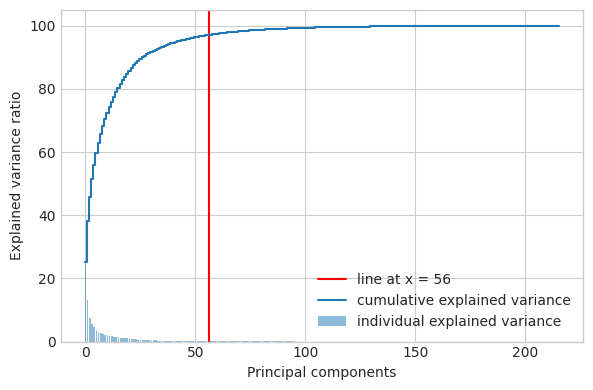

In [245]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [246]:
labels = np.unique(y, axis=0)

In [247]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

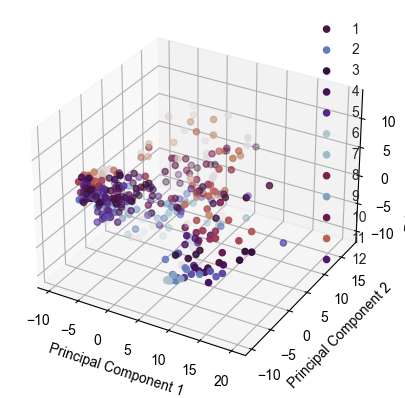

In [248]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

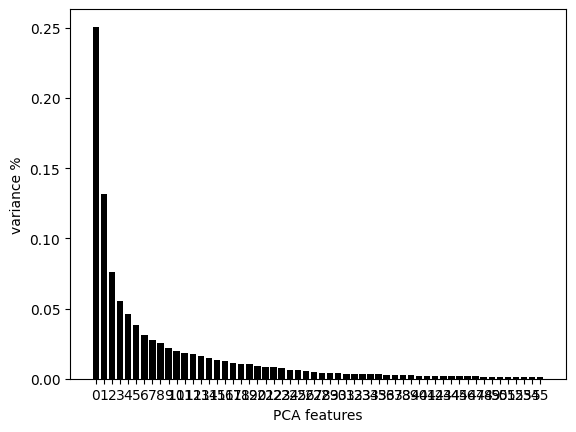

In [249]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [250]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [251]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,-0.137247,5.775594,2.890643,-6.084717,-1.286768,0.425769,-1.017244,-2.854918,2.079346,-0.746160,...,-0.879740,0.050308,1.262401,-0.322593,0.680216,-0.087637,0.490717,0.183621,-0.597949,0.067836
1,-3.820360,-0.518251,-0.614671,-1.033668,-1.091577,1.267965,-1.741313,-0.554959,-0.245753,-0.471019,...,-0.076634,0.106257,0.130938,-0.057734,0.017564,0.080735,-0.013501,-0.116214,-0.235150,-0.044367
2,-0.362249,3.179349,-5.016968,0.454519,2.539709,0.669356,-1.048083,0.114663,1.158171,-1.644861,...,0.710692,0.249417,0.485504,0.541136,-1.238944,-0.436698,0.031253,-0.396890,-0.390360,0.302356
3,0.960293,6.811742,3.790402,-6.181368,0.339010,-0.420269,-4.608297,-1.168979,1.459492,-2.673803,...,-0.719443,-0.219937,-0.445770,0.755047,0.334245,-0.188918,0.295756,-0.737468,-0.453943,-0.031210
4,-5.601630,-2.701501,-2.933391,0.167349,0.699347,0.450083,-2.141248,0.138236,-0.200440,-0.031457,...,-0.127187,-0.356774,-0.011411,0.313533,0.168116,0.053196,-0.010690,0.177897,-0.250890,0.143564


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

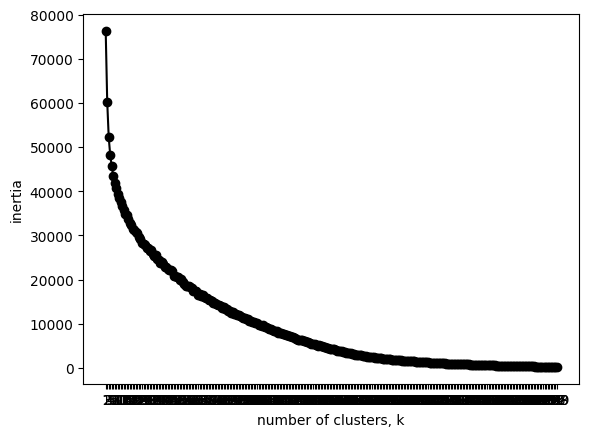

In [252]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [253]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  58


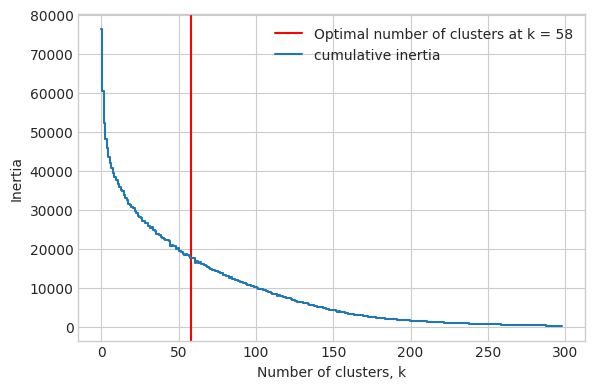

In [254]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [255]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
